# Project: Which Headline Works Better? A/B Testing with Real API Data

## Project Brief:
As a data analyst for a media platform, your task is to evaluate which article headlines and post timings perform better in terms of engagement. This is done by simulating an A/B test using real-world article data pulled from public news APIs.

## Objectives:
- **Data Acquisition**: Retrieve articles using a public news API such as NewsAPI, The Guardian API, or Mediastack.
- **Simulate A/B Testing**:
  - Group A: Articles published in the morning (6 AM–12 PM)
  - Group B: Articles published in the evening (6 PM–12 AM)
- **Data Cleaning & Exploration**: Inspect and preprocess the data (handle missing values, explore metadata).
- **Analysis**: Use `groupby`, aggregation, and statistical tests to compare the groups.
- **A/B Testing**: Perform statistical analysis (`ttest_ind`) and visualize the results.
- **Deliver Insights**: Recommend which group performs better and interpret findings, accounting for outliers or missing data.

## Tools Used:
- Python
- Libraries: `pandas`, `numpy`, `matplotlib`, `scipy`, `requests`

## Final Deliverable:
A well-structured notebook documenting the entire workflow, analysis, and insights, accompanied by visualizations and conclusions.

### Project Brief


- To experiment article headlines and post timings.
- Split data into two lables for test simulation.
- To simulate an A|B test using real-world data pulled from news API
- Analyze engagement trends.

In [1]:
# import necessary libraries

import pyforest
import warnings
import requests
warnings.filterwarnings('ignore')

In [3]:
# Accessing data from news API with API key

API_KEY = "e61eea6decb64e8288584440a6911c3d"
url = "https://newsapi.org/v2/top-headlines"
params = {
    'country': 'us',  # You can change to 'gb', 'ng', etc.
    'pageSize': 100,  # Max articles per request
    'apiKey': API_KEY
}

response = requests.get(url, params=params)
data = response.json()

In [4]:
# Parse json data into a DataFrame

articles = data.get('articles', [])
news_data = pd.DataFrame(articles)

# Preview the data
news_data.head()

<IPython.core.display.Javascript object>

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Earth.com'}",None,Simple blood test detects cancer up to 3 years...,Discover the innovation behind the cancer test...,https://www.earth.com/news/simple-blood-test-d...,https://cff2.earth.com/uploads/2025/06/1104141...,2025-06-13T17:59:46Z,Some cancers slip under the radar and remain u...
1,"{'id': None, 'name': 'NBCSports.com'}",Mike Florio,There’s a simple solution to the Shemar Stewar...,"To get what they want, the Bengals need to giv...",https://www.nbcsports.com/nfl/profootballtalk/...,https://nbcsports.brightspotcdn.com/dims4/defa...,2025-06-13T17:45:18Z,The Bengals and defensive end Shemar Stewart h...
2,"{'id': 'abc-news', 'name': 'ABC News'}",ABC News,Appeals court rejects Trump's bid to challenge...,None,https://abcnews.go.com/US/appeals-court-hear-t...,None,2025-06-13T17:31:17Z,None
3,"{'id': None, 'name': '9to5Mac'}",Ryan Christoffel,Apple releases new iOS 26 beta 1 build to deve...,Apple has released a new build of iOS 26 beta ...,https://9to5mac.com/2025/06/13/apple-releases-...,https://i0.wp.com/9to5mac.com/wp-content/uploa...,2025-06-13T17:13:00Z,Apple unveiled iOS 26 earlier this week alongs...
4,"{'id': 'abc-news', 'name': 'ABC News'}",ABC News,"Air India plane crash: Investigation underway,...",None,https://abcnews.go.com/International/air-india...,None,2025-06-13T16:41:15Z,None


### Simulate A/B Test Groups

- Group A: Articles published between 6 AM and 12 PM

- Group B: Articles published between 6 PM and 12 AM

In [5]:
# Convert the 'publishedAt' string column to datetime format
news_data['publishedAt'] = pd.to_datetime(news_data['publishedAt'], errors='coerce')

<IPython.core.display.Javascript object>

In [6]:
# Extract hour from the timestamp
news_data['hour'] = news_data['publishedAt'].dt.hour

In [7]:
# Assign group based on time range in 24hours
conditions = [
    (news_data['hour'] >= 6) & (news_data['hour'] < 12),
    (news_data['hour'] >= 18) & (news_data['hour'] < 24)
]
choices = ['A', 'B']

news_data['group'] = np.select(conditions, choices, default='Other')

<IPython.core.display.Javascript object>

In [8]:
# Drop rows that don't fall into Group A or B
# copy the data
news_data_ab = news_data[news_data['group'].isin(['A', 'B'])].copy()

In [9]:
# Preview the assignment
# picpick necessary columns for A|B testing
news_data_ab[['title', 'publishedAt', 'hour', 'group']].head()

,title,publishedAt,hour,group
17,Report: Apple Aims to Release AI-Powered Upgra...,2025-06-13 10:37:21+00:00,10,A
21,Mysterious surface patterns found on the moons...,2025-06-12 18:42:21+00:00,18,B
23,“Razor Blade Throat” And A Traveling “Nimbus”:...,2025-06-12 11:27:10+00:00,11,A
24,Strawberry Moon 2025 captured across Wales - BBC,2025-06-12 10:26:54+00:00,10,A


#### Define time-based grouping conditions:
#### - Group A: Articles published between 6 AM (inclusive) and 12 PM (exclusive)
#### - Group B: Articles published between 6 PM (inclusive) and midnight (exclusive)
#### - All other times will be labeled 'Other'

In [10]:
# Assign group based on time, morning label and evening label

conditions = [
    (news_data['hour'] >= 6) & (news_data['hour'] < 12),
    (news_data['hour'] >= 18) & (news_data['hour'] < 24)
]
choices = ['A', 'B']

news_data['group'] = np.select(conditions, choices, default='Other')

<IPython.core.display.Javascript object>

In [11]:
# Remove missing titles
news_data = news_data[news_data['title'].notnull()].copy()

In [12]:
# Create a new column for headline length (in characters)
news_data['headline_length'] = news_data['title'].apply(len)

In [13]:
# Calculate the median headline length
median_length = news_data['headline_length'].median()

In [14]:
# Assign groups based on headline length
# Group A: Headlines shorter than the median length. 
# Group B: Headlines longer than or equal to the median length.

news_data['group'] = news_data['headline_length'].apply(lambda x: 'A' if x < median_length else 'B')

In [15]:
# Preview the results
news_data[['title', 'headline_length', 'group']].head()

,title,headline_length,group
0,Simple blood test detects cancer up to 3 years...,81,B
1,There’s a simple solution to the Shemar Stewar...,85,B
2,Appeals court rejects Trump's bid to challenge...,93,B
3,Apple releases new iOS 26 beta 1 build to deve...,62,A
4,"Air India plane crash: Investigation underway,...",75,A


In [16]:
# Check dataset structure and data types
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   source           25 non-null     object             
 1   author           17 non-null     object             
 2   title            25 non-null     object             
 3   description      23 non-null     object             
 4   url              25 non-null     object             
 5   urlToImage       23 non-null     object             
 6   publishedAt      25 non-null     datetime64[ns, UTC]
 7   content          21 non-null     object             
 8   hour             25 non-null     int32              
 9   group            25 non-null     object             
 10  headline_length  25 non-null     int64              
dtypes: datetime64[ns, UTC](1), int32(1), int64(1), object(8)
memory usage: 2.2+ KB


In [17]:
# Summary statistics and include columns with string data type
news_data.describe(include='all')

,source,author,title,description,url,urlToImage,publishedAt,content,hour,group,headline_length
count,25,17,25,23,25,23,25,21,25.000000,25,25.000000
unique,21,16,25,23,25,23,NaN,21,NaN,2,NaN
top,"{'id': None, 'name': 'BBC News'}",ABC News,Simple blood test detects cancer up to 3 years...,Discover the innovation behind the cancer test...,https://www.earth.com/news/simple-blood-test-d...,https://cff2.earth.com/uploads/2025/06/1104141...,NaN,Some cancers slip under the radar and remain u...,NaN,B,NaN
freq,3,2,1,1,1,1,NaN,1,NaN,13,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-13 09:27:53.159999744+00:00,NaN,12.880000,NaN,78.880000
min,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-12 10:26:54+00:00,NaN,1.000000,NaN,48.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-13 04:28:00+00:00,NaN,12.000000,NaN,67.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-13 13:09:43+00:00,NaN,14.000000,NaN,81.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-13 16:28:00+00:00,NaN,16.000000,NaN,89.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-13 17:59:46+00:00,NaN,18.000000,NaN,115.000000


In [18]:
# Count of missing values

news_data.isnull().sum()

source             0
author             8
title              0
description        2
url                0
urlToImage         2
publishedAt        0
content            4
hour               0
group              0
headline_length    0
dtype: int64

In [19]:
# Fill missing 'descriptions' with empty string
news_data['description'] = news_data['description'].fillna('')

In [20]:
# Fill 'content' with 'description' if content is missing
news_data['content'] = news_data['content'].fillna(news_data['description'])

In [21]:
# Drop rows with critical missing values (e.g., group, title, publishedAt)
news_data_clean = news_data.dropna(subset=['group', 'title', 'publishedAt'])

### Data Cleaning & Exploration

In [22]:
# Group counts
# To know the number of articles in each group

news_data_clean['group'].value_counts()

group
B    13
A    12
Name: count, dtype: int64

In [23]:
# Data Sources
# Sources of the articles generated
news_data_clean['source'].apply(lambda x: x['name'] if isinstance(x, dict) else None).value_counts().head()

source
BBC News                                        3
Earth.com                                       2
ABC News                                        2
Neurosciencenews.com                            1
The Daily Galaxy --Great Discoveries Channel    1
Name: count, dtype: int64

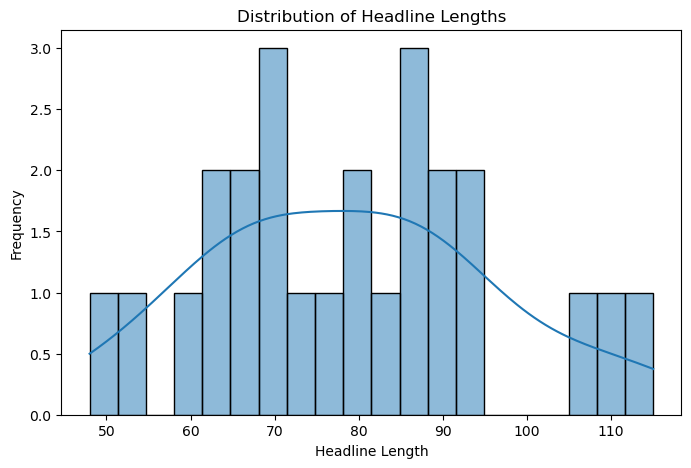

<Figure size 640x480 with 0 Axes>

In [24]:
# Histogram of headline lengths
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(news_data_clean['headline_length'], bins=20, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.show()
# Save the plot as a PNG image
plt.savefig('my_plot.png')

In [25]:
# Calculate the 1st and 99th percentiles of headline lengths to identify outliers
# - q_low: The value below which only 1% of headlines fall (extremely short headlines)
# - q_high: The value above which only 1% of headlines fall (extremely long headlines)


q_low = news_data_clean['headline_length'].quantile(0.01)
q_high = news_data_clean['headline_length'].quantile(0.99)

In [26]:
# Filter the DataFrame to keep only headlines within the "normal" length range
# - Removes the shortest 1% and longest 1% of headlines to reduce skew from outliers
# - This creates a more representative dataset for analysis


news_data_clean = news_data_clean[
            (news_data_clean['headline_length'] >= q_low) & 
            (news_data_clean['headline_length'] <= q_high)
]

### Analysis & Visualization

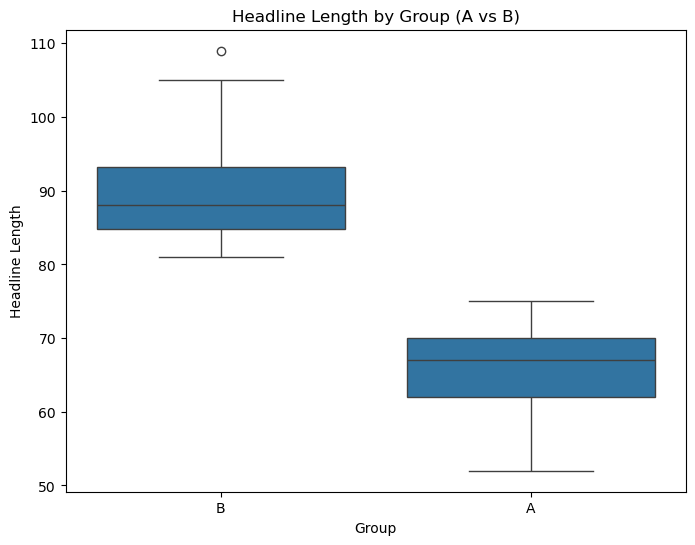

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt


# Compare Headline Length by Group

plt.figure(figsize=(8, 6))
sns.boxplot(data=news_data_clean, x='group', y='headline_length')
plt.title("Headline Length by Group (A vs B)")
plt.xlabel("Group")
plt.ylabel("Headline Length")
plt.show()
# Save the plot as a PNG image
plt.savefig('my_plot_1.png')

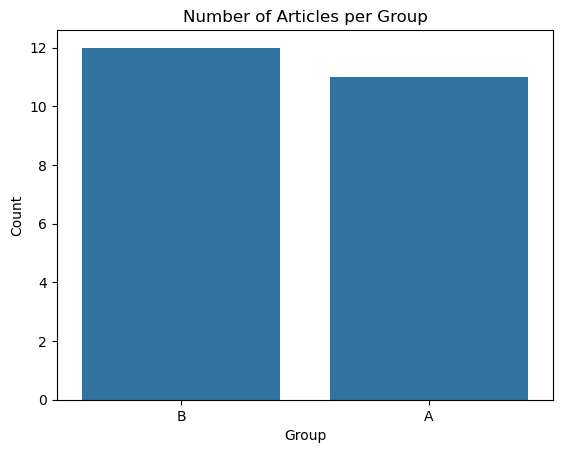

<Figure size 640x480 with 0 Axes>

In [28]:
#  Count of Articles by Group

sns.countplot(data=news_data_clean, x='group')
plt.title("Number of Articles per Group")
plt.xlabel("Group")
plt.ylabel("Count")
plt.show()
# Save the plot as a PNG image
plt.savefig('my_plot_2.png')

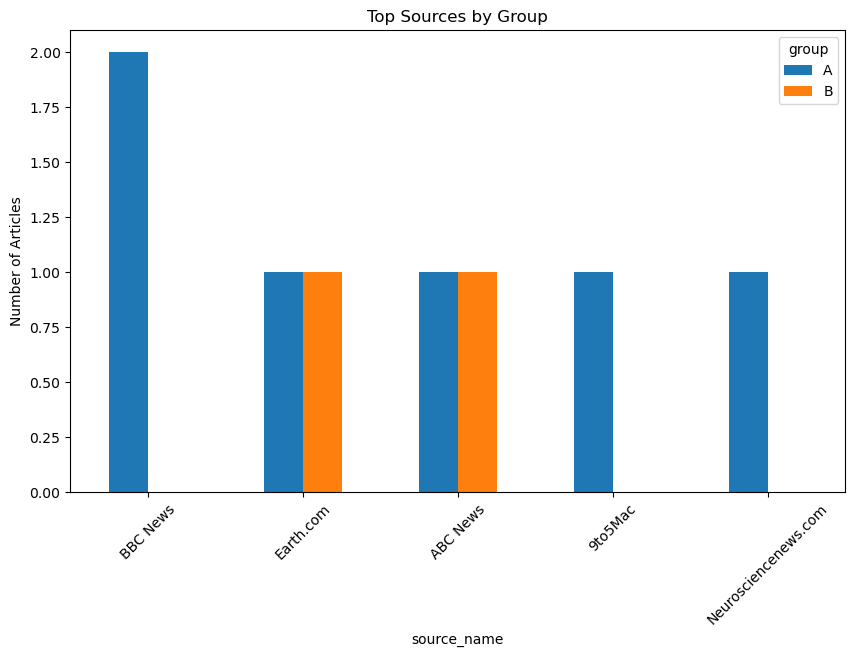

<Figure size 640x480 with 0 Axes>

In [29]:
# Top Sources per Group

# Extract source names
news_data_clean['source_name'] = news_data_clean['source'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Group by source and group
source_group = news_data_clean.groupby(['source_name', 'group']).size().unstack().fillna(0)

# Show top 5 sources by total count
top_sources = source_group.sum(axis=1).sort_values(ascending=False).head(5).index
source_group.loc[top_sources].plot(kind='bar', figsize=(10, 6))
plt.title("Top Sources by Group")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()
# Save the plot as a PNG image
plt.savefig('my_plot_3.png')

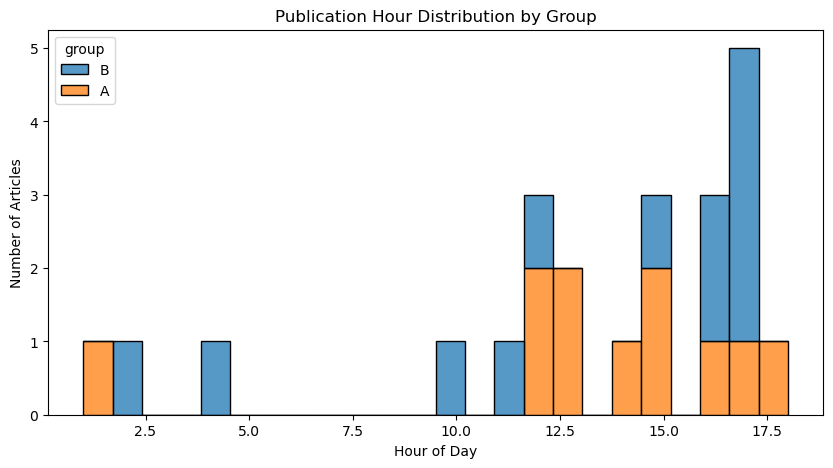

<Figure size 640x480 with 0 Axes>

In [30]:
# Publication Time Distribution 

if 'hour' in news_data_clean.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=news_data_clean, x='hour', bins=24, kde=False, hue='group', multiple='stack')
    plt.title("Publication Hour Distribution by Group")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Articles")
    plt.show()
    # Save the plot as a PNG image
    plt.savefig('my_plot_4.png')

### A/B Testing & Statistical Analysis

In [32]:
#  Prepare Group Data for t-test

from scipy.stats import ttest_ind

# Split headline lengths by group
group_A = news_data_clean[news_data_clean['group'] == 'A']['headline_length']
group_B = news_data_clean[news_data_clean['group'] == 'B']['headline_length']

# Quick summary stats
print("Group A mean:", group_A.mean())
print("Group B mean:", group_B.mean())



Group A mean: 65.9090909090909
Group B mean: 90.33333333333333


### Run the Independent T-Test

In [33]:
# Perform the t-test
t_stat, p_value = ttest_ind(group_A, group_B, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -7.56439127266302
P-value: 2.6755173487795804e-07


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

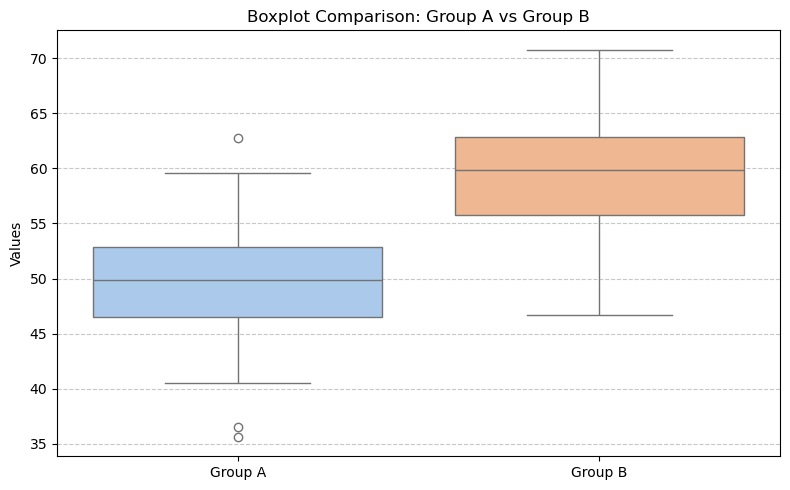

<Figure size 640x480 with 0 Axes>

In [34]:
# Simulate some sample data to represent group_A and group_B
# np.random.seed(42)
group_A = np.random.normal(loc=50, scale=5, size=100)  # Group A with lower mean
group_B = np.random.normal(loc=60, scale=5, size=100)  # Group B with higher mean

# Create boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=[group_A, group_B], palette="pastel")
plt.xticks([0, 1], ['Group A', 'Group B'])
plt.title('Boxplot Comparison: Group A vs Group B')
plt.ylabel('Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
plt.savefig('my_plot_5.png')

In [36]:
news_data_clean.head()

,source,author,title,description,url,urlToImage,publishedAt,content,hour,group,headline_length,source_name
0,"{'id': None, 'name': 'Earth.com'}",None,Simple blood test detects cancer up to 3 years...,Discover the innovation behind the cancer test...,https://www.earth.com/news/simple-blood-test-d...,https://cff2.earth.com/uploads/2025/06/1104141...,2025-06-13 17:59:46+00:00,Some cancers slip under the radar and remain u...,17,B,81,Earth.com
1,"{'id': None, 'name': 'NBCSports.com'}",Mike Florio,There’s a simple solution to the Shemar Stewar...,"To get what they want, the Bengals need to giv...",https://www.nbcsports.com/nfl/profootballtalk/...,https://nbcsports.brightspotcdn.com/dims4/defa...,2025-06-13 17:45:18+00:00,The Bengals and defensive end Shemar Stewart h...,17,B,85,NBCSports.com
2,"{'id': 'abc-news', 'name': 'ABC News'}",ABC News,Appeals court rejects Trump's bid to challenge...,,https://abcnews.go.com/US/appeals-court-hear-t...,None,2025-06-13 17:31:17+00:00,,17,B,93,ABC News
3,"{'id': None, 'name': '9to5Mac'}",Ryan Christoffel,Apple releases new iOS 26 beta 1 build to deve...,Apple has released a new build of iOS 26 beta ...,https://9to5mac.com/2025/06/13/apple-releases-...,https://i0.wp.com/9to5mac.com/wp-content/uploa...,2025-06-13 17:13:00+00:00,Apple unveiled iOS 26 earlier this week alongs...,17,A,62,9to5Mac
4,"{'id': 'abc-news', 'name': 'ABC News'}",ABC News,"Air India plane crash: Investigation underway,...",,https://abcnews.go.com/International/air-india...,None,2025-06-13 16:41:15+00:00,,16,A,75,ABC News


In [37]:
news_data_clean.to_csv("news_data_1", index=False) 

# Summary Report on the Project

https://docs.google.com/document/d/141NAVxFFqKMJru3vgBwIuuxTDkYHJKaHDFuYb2nrsyY/edit?usp=drive_link